This notebook introduces the **eager execution** for TensorFlow, a novel low-level API allowing for a more dynamic programming flow. Eager greatly simplifies how you can write and debug models, softening the complete separation between the *definition* of a graph and its *execution* in the standard TensorFlow API.

## Table of contents:

>[Static and dynamic graph computation](#scrollTo=JOX81EBYEfJ6)

>[Enabling eager execution](#scrollTo=qAFSauM9nKwN)

>>[Additional: experimenting with eager functionalities in the nightly branch](#scrollTo=kBNAHEBU9Uvj)

>[A neural network with eager execution](#scrollTo=5P0ToXGupvlu)

>>[Loading data](#scrollTo=tSheSH8ArO4N)

>>[Variables and gradients in TFE](#scrollTo=8azE_xwVr4ak)

>>>[Eager variables and NumPy compatibility](#scrollTo=2lkQTVjyiHN-)

>>>[Computing gradients in TF Eager](#scrollTo=VtfqaWPyiLJG)

>>[Defining models using layers](#scrollTo=MZL5tCFWPaat)

>>[Handling the input pipeline](#scrollTo=kfB5YWC2xnus)

>>[Gradients' computation and model's optimization](#scrollTo=ehLIBkN23ltL)

>>[Evaluating the model and plotting the results](#scrollTo=XecSJK4r9PD1)

>>>[Computing and visualizing metrics](#scrollTo=5ix3nr8wqglP)

>>>[Saving summaries on disk and working with the TensorBoard](#scrollTo=jlZIDj8VqjRz)

>[Advanced features](#scrollTo=C9PxnV3x_EJo)

>>[Enabling GPU execution](#scrollTo=rdTN7c_k_GsN)

>>[Saving and reloading](#scrollTo=b_I-_yQnB_Cw)

>[Final remarks](#scrollTo=fVtZn99KDDSG)



# Static and dynamic graph computation

To understand the need for Eager, consider a simple example:

In [1]:
import tensorflow as tf
a = tf.constant(3.0)
b = a + 2.0
print(b)

Tensor("add:0", shape=(), dtype=float32)


If you never played with the low-level components of TensorFlow before, you probably would have expected the print operation to show the value of `b` at this point. Instead, we have to fetch the value of the variable by running the operation inside a `Session` object:



In [6]:
sess = tf.Session()
with sess.as_default():
  print(sess.run(b))

5.0


Now, let's keep exploring and add some intermediate computations:

In [7]:
with tf.Session() as sess:
    c = sess.run(1.5*b)
print(b)

Tensor("add:0", shape=(), dtype=float32)


Once again, you might have expected to obtain the value of ```b```, since it was clearly computed to obtain ```c```. While there are several methods to get it (such as calling its ```eval``` method), none of them is as satisfying as writing pure NumPy code, and none of them lends itself to an immediate debug using a visual editor. 

Now consider the same code written with the novel [eager execution](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager) enabled:

```python
a = tf.constant(3.0)
b = a + 2.0
print(b) # print tf.Tensor(5.0, shape=(), dtype=float32)
```

We can now get the value immediately! With eager execution enabled, definition and execution are tied, with one lazily following the other automatically. Let us see how to enable it before moving on to more interesting examples.

# Enabling eager execution

In order to enable eager execution, we need to install the latest version of TensorFlow (v1.5 as of this writing). To upgrade from terminal (replace **tensorflow** with **tensorflow-gpu** for the version with GPU support):

In [1]:
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: six>=1.10.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: wheel>=0.26 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: protobuf>=3.4.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: grpcio>=1.8.6 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: astor>=0.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: termcolor>=1.1.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: gast>=0.2.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: tensorboard<1.7.0,>=1.6.0 in /usr/local/lib/python3.6/dist-packages (from tensorflow)
Requirement already up-to-date: absl-py>=0.1.6 in /usr/lo

Eager is included as an experimental feature inside the contrib module:

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import numpy as np
tfe.enable_eager_execution()

The previous instruction should always be run at the beginning of a program. If it fails, simply reset the runtime of the notebook from Runtime >> Restart runtime.

## Additional: experimenting with eager functionalities in the nightly branch

Since Eager is under development, new features are being constantly included (e.g., additional layers) and are not immediately available on the main branch. If you want to experiment with the latest Eager module, the recommended way is to setup a [virtual environment](https://www.tensorflow.org/install/install_linux#InstallingVirtualenv) and install the nightly branch of TF.

The virtual environment can be created using either [virtualenv](https://virtualenv.pypa.io/en/stable/installation/) or the [Anaconda distribution](https://conda.io/docs/user-guide/tasks/manage-environments.html), and the installation is specific to the OS. For example, using virtualenv on a Unix platform we can create and activate a new environment as follows: 

```python
virtualenv --system-site-packages -p python3 tfeager
source ~/tfeager/bin/activate
```

The [official installation guide of TensorFlow](https://www.tensorflow.org/install/) describes the proper commands for other systems as well. Once a clean virtual environment is running, you can install the nightly build of TensorFlow as a standard Python package:

In [0]:
!pip install tf-nightly # replace with tf-nightly-gpu for GPU support

# A neural network with eager execution

## Loading data

We are going to code a simple neural network on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) to highlight some differences with the standard TF execution. For the purpose of this demo, we will load the scikit-learn version of Iris, preprocess it, and split it into two sets:

In [0]:
from sklearn import datasets, preprocessing, model_selection
data = datasets.load_iris()
# Feature normalization on the input
X = preprocessing.MinMaxScaler(feature_range=(-1,+1)).fit_transform(data['data'])
# Encode the output using the one-hot encoding
y = preprocessing.OneHotEncoder(sparse=False).fit_transform(data['target'].reshape(-1, 1))
# Split in train/test sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify=y)

## Variables and gradients in TFE

### Eager variables and NumPy compatibility

Before going straight to the model definition, let us see how variables and gradients are handled under the eager execution. First, Eager comes with its own implementation of variables, which are automatically initalized when requested:

In [4]:
W = tfe.Variable(0.5, name='w')
print(W)

<tf.Variable 'w:0' shape=() dtype=float32, numpy=0.5>


To further simplify development, in Eager you can mix TF Tensors and NumPy arrays with automatic casting underneath:

In [5]:
print(W + np.asarray([1, 3]))

tf.Tensor([1.5 3.5], shape=(2,), dtype=float32)


And you can extract the NumPy representation of a Tensor with a new `numpy` method:



In [6]:
W.numpy()

0.5

Finally, we can initialize an Eager variable using the standard `get_variable` method, by specifying a new flag:



In [7]:
W2 = tf.get_variable('W2', shape=[1], use_resource=True)
print(W2)

<tf.Variable 'W2:0' shape=(1,) dtype=float32, numpy=array([-1.6226029], dtype=float32)>


### Computing gradients in TF Eager

Gradients computation is where the real simplicity of Eager comes to fruition. In the standard TF API, functions and their gradients are both nodes in the computational graph, and the `gradients` method is used to add the corresponding nodes automatically:


```python
# Will throw an error if eager execution is enabled
f_grad = tf.gradients(1.0 + W, W)
```



When eager execution is enabled, functions can be defined using standard Python syntax, and the `tfe.gradients_function` will return the handle to another *Python* function to compute the gradient:



In [8]:
def f(W):
  return 1.0 + 2.0*W
f_grad = tfe.gradients_function(f)
print(f_grad(0.3))

[<tf.Tensor: id=42, shape=(), dtype=float32, numpy=2.0>]




In programming terms, we are now dealing with an **imperative** definition, as opposed to a **declarative** interface.



We can also use `tfe.value_and_gradients_function` to compute the value and the gradients simultaneously. By default, the gradient is computed with respect to all the parameters of the function. We can specify a list of parameters explicitly, either by name or by indexing:



In [10]:
a = tf.constant(0.3)
b = tf.constant(0.5)

def f(a, b):
  return a*b

# Return the gradient for the first parameter only
print(tfe.gradients_function(f, params=[0])(1.0, 1.0))

# Alternative definition (by name)
# print(tfe.gradients_function(f, params=['a'])(1.0, 1.0))

[<tf.Tensor: id=47, shape=(), dtype=float32, numpy=1.0>]


And we can chain the use of `tfe.gradients_function` to get higher-order derivatives:

In [11]:
def f(W):
  return tf.square(W)

# Second-order derivative
f_gg = tfe.gradients_function(tfe.gradients_function(f))
f_gg(1.0)

[<tf.Tensor: id=57, shape=(), dtype=float32, numpy=2.0>]

## Defining models using layers

While we can use variables to directly define our model, this is clearly unpractical as soon as the model starts to get complicated. To simplify the development, there are a number of Eager strategies we can adopt.

First, we can use all the blocks defined in the [layers' module](https://www.tensorflow.org/api_docs/python/tf/layers), which automatically detect we are working in eager mode and initialize their variables accordingly. For example, this is a simple linear model:

In [0]:
lin = tf.layers.Dense(units=3, use_bias=True, activation=None)

We can stack multiple layers to create more complicated models. For example, a neural network with one hidden layer and dropout in the middle:

In [0]:
hid = tf.layers.Dense(units=10, activation=tf.nn.relu)
drop = tf.layers.Dropout()
out = tf.layers.Dense(units=3, activation=None)

def nn_model(x, training=False):
  return out(drop(hid(x), training=training))

Note the `training` flag we can use to differentiate between training and test (for the dropout layer). This is a standard practice for all layers that have a different behaviour in the two cases.



For more complicated models, it becomes useful to have an object-oriented interface to keep track of how the layers are organized. Eager provides such a functionality in the [Network]() object. Consider again a neural network with just one hidden layer:

In [0]:
class SingleHiddenLayerNetwork(tfe.Network):
  def __init__(self):
    super(SingleHiddenLayerNetwork, self).__init__()
    # Each layer is registered using the track_layer function
    self.hidden_layer = self.track_layer(tf.layers.Dense(10, activation=tf.nn.tanh, use_bias=True))
    self.output_layer = self.track_layer(tf.layers.Dense(3, use_bias=True, activation=None))

  def call(self, x):
    return self.output_layer(self.hidden_layer(x))

net = SingleHiddenLayerNetwork()

It is relatively similar to the [functional interface of Keras](https://keras.io/getting-started/functional-api-guide/), the main difference being that we need to call `track_layer` in the initialization phase to register all the layers of our model. Note that variables are not yet initialized:



In [15]:
len(net.variables)

0

However, it is enough to use the model a single time to automatically trigger the initialization. Networks objects can be called as if they were functions:

In [0]:
net(tf.constant(X_train[0:1]))
len(net.variables)

Networks have several additional utilities to handle the models. For example, we can count the number of adaptable parameters of the model:

In [17]:
net.count_params()

83

For simple sequential models, Eager also provides a short-hand with the `Sequential` object; the following is equivalent to the previous model definition:



In [0]:
net = tfe.Sequential(layers_funcs=[
    tf.layers.Dense(10, activation=tf.nn.tanh, use_bias=True), 
    tf.layers.Dense(3, use_bias=True, activation=None)
])

## Handling the input pipeline

The next step is to define the input function to handle our dataset. Since the latest versions of TF, the preferred method is the use of the [data pipeline with the Dataset object](https://www.tensorflow.org/programmers_guide/datasets):

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

To cycle over the data, we can use the Eager module `tfe.Iterator` instead of `tf.data.Iterator`, which acts as a standard Python iterator. For example, we can cycle over each batch in the dataset and print the proportion of the first class in each batch:


In [22]:
import numpy as np
for xb,yb in tfe.Iterator(train_dataset.batch(32)):
  print('Percentage of class [0]: ', tf.reduce_mean(yb[:, 0]).numpy()*100, ' %')

Percentage of class [0]:  31.25  %
Percentage of class [0]:  34.375  %
Percentage of class [0]:  37.5  %
Percentage of class [0]:  25.0  %


`from_tensor_slices` creates a dataset having one element for each row of our original tensors. If you don't need batching, `from_tensors` will treat the entire tensor as a single element:

In [26]:
train_dataset_alt = tf.data.Dataset.from_tensors((X_train, y_train))
for xb, yb in tfe.Iterator(train_dataset_alt):
  # Check that the batch is equivalent to the entire training array
  assert(np.all(X_train == xb.numpy()))
  # Compute the percentage of labels for the first class
  print('Percentage of class [0] (entire dataset): ', tf.reduce_mean(yb[:, 0]).numpy()*100, ' %')

Percentage of class [0] (entire dataset):  33.035714285714285  %


We can apply further transformations to the dataset before processing it, such as repeating the entire dataset twice:

In [23]:
for xb,yb in tfe.Iterator(train_dataset.repeat(2).batch(32)):
  print('Percentage of class [0]: ', tf.reduce_mean(yb[:, 0]).numpy()*100, ' %')

Percentage of class [0]:  31.25  %
Percentage of class [0]:  34.375  %
Percentage of class [0]:  37.5  %
Percentage of class [0]:  31.25  %
Percentage of class [0]:  28.125  %
Percentage of class [0]:  34.375  %
Percentage of class [0]:  34.375  %


Or shuffling the dataset each time we cycle over it:

In [24]:
for xb,yb in tfe.Iterator(train_dataset.shuffle(1000).batch(32)):
  print('Percentage of class [0]: ', tf.reduce_mean(yb[:, 0]).numpy()*100, ' %')

Percentage of class [0]:  37.5  %
Percentage of class [0]:  28.125  %
Percentage of class [0]:  40.625  %
Percentage of class [0]:  18.75  %


The parameter for the `shuffle` method is a buffer dimension: if we need to process very large datasets, it would be unfeasible to shuffle them uniformly. In this case, the buffer size specifies the dimension of blocks that we will randomly shuffle. If we set the buffer parameter larger than the size of the dataset, this is equivalent to a uniform shuffling.



## Gradients' computation and model's optimization

It is now time to define our cost function:

In [0]:
def loss(net, inputs, labels):
  return tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(
          logits=net(inputs), labels=labels))

We are using the novel `softmax_cross_entropy_with_logits_v2` instead of the older `softmax_cross_entropy_with_logits`, which would throw a warning as it will be deprecated in future releases. The two are identical, except that the new version allows to back-propagate through the labels by default: while this is entirely useless in this case, it is needed when the labels are coming from another neural model (as in [generative networks](https://www.tensorflow.org/api_docs/python/tf/contrib/gan)).



Note again that the cost is defined explicitly as a Python function, instead of as a given node in our TensorFlow graph.

In order to better understand Eager, we are going to explicitly compute the gradients and apply them via the `apply_gradients` function of the optimizer. In particular, `tfe.implicit_gradients` works like `tfe.gradients_function`, but automatically returns the gradients of all variables of our model:

In [0]:
loss_grad = tfe.implicit_gradients(loss)

Once again, another variant is the `implicit_value_and_gradients`, which returns both the value of the function and its gradients:

In [0]:
loss_and_grads = tfe.implicit_value_and_gradients(loss)

Using the first syntax, the optimization cycle is now a trivial matter:

In [31]:
net = SingleHiddenLayerNetwork()
opt = tf.train.AdamOptimizer(learning_rate=0.01)

# Loop over the epochs
for epoch in range(50):
  
  # For each epoch we shuffle the dataset
  for (xb, yb) in tfe.Iterator(train_dataset.shuffle(1000).batch(32)):
    opt.apply_gradients(loss_grad(net, xb, yb))
    
  # Training accuracy at the end of each tenth epoch
  if epoch % 10 == 0:
    print("Epoch %d: Loss on training set : %f" %
              (epoch, loss(net, X_train, y_train).numpy()))

Epoch 0: Loss on training set : 106.719792
Epoch 10: Loss on training set : 41.383423
Epoch 20: Loss on training set : 25.704682
Epoch 30: Loss on training set : 16.612080
Epoch 40: Loss on training set : 11.029074


Note how, when compared to the classical TensorFlow low-level interface, the previous code tends to be more readable, and closely resembles what the code would have looked like had we only used NumPy.

In the latest release, the inner optimization can also be simplified using the standard `minimize` interface of the optimizer, by constructing a parameter-free anonymous function:



In [0]:
opt.minimize(lambda: loss(net, xb, yb))

## Evaluating the model and plotting the results

### Computing and visualizing metrics

Two common debug tools in TensorFlow are the **summaries** and the **metrics**, which have a corresponding new implementation inside Eager. Starting from the latter, a set of pre-defined metrics can be found in the `tfe.metrics` module, which can be used in a standard object-oriented fashion:

In [0]:
accuracy = tfe.metrics.Accuracy()

We can accumulate values inside the metric and print an average result as follows:

In [34]:
accuracy(tf.argmax(net(tf.constant(X_test)), axis=1), tf.argmax(tf.constant(y_test), axis=1))
print('Final test accuracy is: ', accuracy.result().numpy())

Final test accuracy is:  0.9473684210526315


Let us rewrite the optimization code, this time by accumulating the training accuracy at each epoch:

In [0]:
net = SingleHiddenLayerNetwork()
opt = tf.train.AdamOptimizer(learning_rate=0.01)

# Numpy array to keep track of the accuracy
acc_history = np.zeros(50)

# Loop over the epochs
for epoch in range(50):
  
  # Initialize the metric
  accuracy = tfe.metrics.Accuracy()
  
  # For each epoch we shuffle the dataset
  for (xb, yb) in tfe.Iterator(train_dataset.shuffle(1000).batch(32)):
    opt.apply_gradients(loss_grad(net, xb, yb))
    
    # Save the training accuracy on the batch
    accuracy(tf.argmax(net(tf.constant(xb)), axis=1), tf.argmax(tf.constant(yb), axis=1))
  
  # Save the overall accuracy in our vector
  acc_history[epoch] = accuracy.result().numpy()

We can use Matplotlib to plot the resulting accuracy:

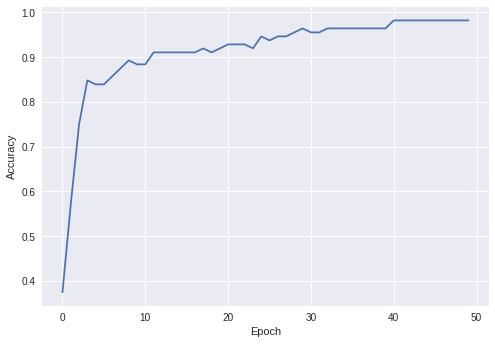

In [36]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(acc_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Saving summaries on disk and working with the TensorBoard

Similarly, Eager comes with its own implementation of the summaries. In order to work with them, we first define a writer on disk:

In [0]:
writer = tf.contrib.summary.create_file_writer('tmp')

In order to save a summary, we need to select the writer as the default one, and tell TF that we want to save summaries everytime they are computed:

In [0]:
with writer.as_default():
  with tf.contrib.summary.always_record_summaries():
      tf.contrib.summary.scalar('scalar_value', 0.5)

Alternatively, we can instruct TF to save summaries only every given number of steps:

In [0]:
with writer.as_default():
  with tf.contrib.summary.record_summaries_every_n_global_steps(5):
      tf.contrib.summary.scalar('scalar_value', 0.5) # Will only save every 5 steps

The 'global step' is a variable inside TF that keeps track of the iterations of our optimization algorithm:

In [40]:
tf.train.get_global_step()

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>

Note that the variable is currently set to 0. If we want to update it correctly, we need to provide the global step during the optimization cycle:

In [41]:
opt.apply_gradients(loss_grad(net, xb, yb), global_step=tf.train.get_or_create_global_step()) # Will apply gradients AND increase the step by one
tf.train.get_global_step()

<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=1>

Alternatively, we can provide our own global step to the summary operation. This is particularly easy in eager mode because we can work with standard int64 values:

In [0]:
with writer.as_default():
  with tf.contrib.summary.record_summaries_every_n_global_steps(5):
      tf.contrib.summary.scalar('scalar_value', 0.5, step=4) # This will save the value on disk

In the following example, we extend again our optimization routine to save the loss value on disk at every iteration:

In [0]:
net = SingleHiddenLayerNetwork()
opt = tf.train.AdamOptimizer(learning_rate=0.01)

with writer.as_default():
    with tf.contrib.summary.always_record_summaries():

        # Loop over the epochs
        for epoch in range(50):

            # For each epoch we shuffle the dataset
            for (xb, yb) in tfe.Iterator(train_dataset.shuffle(1000).batch(32)):
                
                tf.contrib.summary.scalar('loss_value', loss(net, xb,yb))
                opt.minimize(lambda: loss(net, xb,yb), global_step=tf.train.get_or_create_global_step())

Now launch the tensorboard to visualize the loss:

In [21]:
!tensorboard --logdir=tmp

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
TensorBoard 1.6.0 at http://eacb5bd1a82e:6006 (Press CTRL+C to quit)
^C


If you are running this notebook from a local machine, you can navigate to the address above to visualize the training details in the TensorBoard itself:

![alt text](https://iaml.it/screenshots/tensorboard.png)

# Advanced features

## Enabling GPU execution

With Eager, computation on the GPU is not enabled by default (if a GPU is present). We can inspect if we have a GPU on the system easily:

In [44]:
tfe.num_gpus()

1

In order to enable the GPU, we can specify a device explicitly for each operation that we want to run on that device:

In [0]:
with tf.device("/gpu:0"):
  net(X_train[0:1, :])

Alternatively, we can move the data to the GPU before running the computation:

In [60]:
net(tf.constant(X_train[0:1, :]).gpu())

<tf.Tensor: id=78996, shape=(1, 3), dtype=float64, numpy=array([[-1.14483888,  0.18914156,  0.74425629]])>

Given a variable `x` on the GPU, we can perform the inverse operation similarly:


```python
x = x.cpu()
```



## Saving and reloading

Eager provides a simple interface for saving variables on disk:

In [61]:
saver = tfe.Saver([W])
saver.save('tmp/')
saver.restore('tmp/')

INFO:tensorflow:Restoring parameters from tmp/


In order to save a comprehensive snapshot, we can save all variables of the model together with the optimizer's state, e.g.:

In [0]:
all_variables = (net.variables + opt.variables())
tfe.Saver(all_variables).save('tmp/')

We modify one again our training routine, this time by saving all variables at the end of every epoch:

In [0]:
net = SingleHiddenLayerNetwork()
opt = tf.train.AdamOptimizer(learning_rate=0.01)

for epoch in range(50):
  for (xb, yb) in tfe.Iterator(train_dataset.shuffle(1000).batch(32)):
    opt.minimize(lambda: loss(net, xb,yb))
   
  # Get a list of all variables
  all_variables = (net.variables + opt.variables())
  # Save (by specifying the epoch)
  tfe.Saver(all_variables).save('./tmp_folder', global_step=epoch)

Eager provides a simple functionality to restore the latest checkpoint from the disk:

In [65]:
with tfe.restore_variables_on_create(tf.train.latest_checkpoint('./tmp_folder')):
  print(net(X_train[0:1, :])) # Will have the latest weights saved on disk

tf.Tensor([[ 5.92546095  1.61881532 -4.28004004]], shape=(1, 3), dtype=float64)


# Final remarks

In this tutorial, we have seen that developing at a low-level with the new eager execution can be easier (and more simple to debug) that with the standard low-level interface. Since the module is still experimental, some advanced features (such as distributed training of graphs) are not yet available when running in eager mode, and the interface is still prone to minor changes. We refer to the [official guide](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/g3doc/guide.md) for more information on all these aspects.